# Explorig the effects of linearity in OscoNet


In [1]:
%matplotlib inline
from OscopeBootstrap import qvalue
from OscopeBootstrap.create_edge_network_represention import create_edge_network_representation
from OscopeBootstrap.SyntheticDataset import GetSimISyntheticData, true_adj_matrix
from OscopeBootstrap.oscope_tf import bootstrap_hypothesis_test, get_accuracy, get_metrics_for_different_qvalue_thresholds2, get_metrics_for_different_qvalue_thresholds
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple



In [3]:
np.round(3.6)

4.0

## Define a function to simulate perfect oscillators - liner dependency

In [4]:
def GetSimLinearData(NG: int = 15, G: int = 1000, N: int = 100, noiseLevel: int = 0, ngroups: int = 3) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:

    '''
    Generate synthetic data.
   :param NG: half-size of each gene group. For example =3, each group will have 6 co-oscillating genes. 3 of them
   will be strong oscillators and 3 weak (double the noise)
   :param G: number of total genes
   :param N: number of cells
   :param noiseLevel: noise level index (0 to 5 index)
   :param ngroups: number of groups
   :return: dataframe of data of shape (G X G), numpy arrays of true phase and angular
   speed, each a vector of size G

    Reproduced from the original Oscope paper
    https://www.nature.com/articles/nmeth.3549

    We include below the original description from the supplementary material of that paper:
    Sim I: Oscope paper supplementary
    1,000 genes and 100 cells.  90 out of the 1,000 genes
    were  simulated  as  oscillators.
    The  90  oscillators  were  simulated  in  3  frequency  groups,  each
    group contains 30 genes.

     Group 1 and 3 following the same  order,  while  genes  in  group  2  following  another  order.   In
    Sim  I ,  the  relative  speeds  of the  3  groups  are  proportional  to  2:3:6.

    Within each frequency group, genes were further simulated with strong and weak signals.
    Half of the oscillatory genes were simulated as strong oscillators with sigma_g = sigm_str . The other half
    were simulated as weak oscillators with sigma_g = sigma_wk = 2sigma_str .

    Starting phase phi_g varies in different genes within a frequency group.
    *****************
    We here fix the startingphase for the first two groups, whithin the same group for Group 1 and 2, to test for linearty! 
    So no phase shift, but perfect oscillators. Group 3 will have phase shift fr bot strong and weak oscillators.
    ****************
    The remaining genes except the oscillators are called noise
    genes. Noise genes were simulated as random Gaussian noise. The noise level was adjusted to
    be comparable to the average noise signal among all oscillators.

    Simulation study
    the sigma_str varies from 0.05 to 0.4 in 5 steps.
    '''
    assert ngroups <= 3, 'Only 3 groups implemented'
    # Construct oscillatory groups
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]

    # two different orders
    t1 = np.linspace(0, 2*np.pi, N)
    t2 = np.random.permutation(t1)

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    
    startingPhase = np.random.uniform(0, 2*np.pi)
    print('I am in group 1')
    print('NG = {0}'.format(NG))
    for i in range(NG):  # strong oscillators
        #Group 1
        
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    startingPhase = np.random.uniform(0, 2*np.pi)
    for i in range(NG, 2*NG):  # weak oscillators
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    if(ngroups >= 2):
        # Group 2
        print('I am in group 2')
        startingPhase = np.random.uniform(0, 2*np.pi)
        for i in range(2*NG, 3*NG):  # strong oscillators
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        startingPhase = np.random.uniform(0, 2*np.pi)
        for i in range(3*NG, 4*NG):  # weak oscillators
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
    if(ngroups >= 3):
        print('I am in group 3')

        # Group 3
        for i in range(4*NG, 5*NG):  # strong oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 4
            data[i, :] = np.sin(4*t1 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G3SO'+str(i))
        for i in range(5*NG, 6*NG):  # weak oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 4
            data[i, :] = np.sin(4*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G3WO'+str(i))
    print('White noise from {0}'.format(i+1))
    # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))

    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    print(len(geneName))# == G
    assert len(cellName) == N
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed  # return GXN matrix



In [54]:
def GetSimLinearDataWithGaps(NG: int = 15, G: int = 1000, Norig: int = 100, noiseLevel: int = 0, ngroups: int = 3, missing: float=0.2) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:

    '''
    Generate synthetic data.
   :param NG: half-size of each gene group. For example =3, each group will have 6 co-oscillating genes. 3 of them
   will be strong oscillators and 3 weak (double the noise)
   :param G: number of total genes
   :param N: number of cells
   :param noiseLevel: noise level index (0 to 5 index)
   :param ngroups: number of groups
   :param missing: pecentage of missing values. Default 0.2
   :return: dataframe of data of shape (G X G), numpy arrays of true phase and angular
   speed, each a vector of size G

    Reproduced from the original Oscope paper
    https://www.nature.com/articles/nmeth.3549

    We include below the original description from the supplementary material of that paper:
    Sim I: Oscope paper supplementary
    1,000 genes and 100 cells.  90 out of the 1,000 genes
    were  simulated  as  oscillators.
    The  90  oscillators  were  simulated  in  3  frequency  groups,  each
    group contains 30 genes.

     Group 1 and 3 following the same  order,  while  genes  in  group  2  following  another  order.   In
    Sim  I ,  the  relative  speeds  of the  3  groups  are  proportional  to  2:3:6.

    Within each frequency group, genes were further simulated with strong and weak signals.
    Half of the oscillatory genes were simulated as strong oscillators with sigma_g = sigm_str . The other half
    were simulated as weak oscillators with sigma_g = sigma_wk = 2sigma_str .

    Starting phase phi_g varies in different genes within a frequency group.
    *****************
    We here fix the startingphase for the first two groups, whithin the same group for Group 1 and 2, to test for linearty! 
    So no phase shift, but perfect oscillators. Group 3 will have phase shift fr bot strong and weak oscillators.
    ****************
    The remaining genes except the oscillators are called noise
    genes. Noise genes were simulated as random Gaussian noise. The noise level was adjusted to
    be comparable to the average noise signal among all oscillators.

    Simulation study
    the sigma_str varies from 0.05 to 0.4 in 5 steps.
    '''
    assert ngroups <= 3, 'Only 3 groups implemented'
    # Construct oscillatory groups
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]
    perc=1-missing #percent of values TO KEEP
    # two different orders
    t1orig = np.linspace(0, 2*np.pi, Norig)
    N=np.round(0.8*Norig).astype(int)
    t1=np.random.choice(t1orig,N,replace=False)
    t1=np.sort(t1)
    t2 = np.random.permutation(t1)

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    
    startingPhase = np.random.uniform(0, 2*np.pi)
    print('I am in group 1')
    print('NG = {0}'.format(NG))
    for i in range(NG):  # strong oscillators
        #Group 1
        
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    startingPhase = np.random.uniform(0, 2*np.pi)
    for i in range(NG, 2*NG):  # weak oscillators
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    if(ngroups >= 2):
        # Group 2
        print('I am in group 2')
        startingPhase = np.random.uniform(0, 2*np.pi)
        for i in range(2*NG, 3*NG):  # strong oscillators
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        startingPhase = np.random.uniform(0, 2*np.pi)
        for i in range(3*NG, 4*NG):  # weak oscillators
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
    if(ngroups >= 3):
        print('I am in group 3')

        # Group 3
        for i in range(4*NG, 5*NG):  # strong oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 4
            data[i, :] = np.sin(4*t1 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G3SO'+str(i))
        for i in range(5*NG, 6*NG):  # weak oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 4
            data[i, :] = np.sin(4*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G3WO'+str(i))
    print('White noise from {0}'.format(i+1))
    # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))

    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    print(len(geneName))# == G
    assert len(cellName) == N
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed  # return GXN matrix



In [55]:
def GetSimLinearData2(NG: int = 15, G: int = 1000, N: int = 100, noiseLevel: int = 0, ngroups: int = 3) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:

    '''
    Generate synthetic data.
   :param NG: half-size of each gene group. For example =3, each group will have 6 co-oscillating genes. 3 of them
   will be strong oscillators and 3 weak (double the noise)
   :param G: number of total genes
   :param N: number of cells
   :param noiseLevel: noise level index (0 to 5 index)
   :param ngroups: number of groups
   :return: dataframe of data of shape (G X G), numpy arrays of true phase and angular
   speed, each a vector of size G

    Reproduced from the original Oscope paper
    https://www.nature.com/articles/nmeth.3549

    We include below the original description from the supplementary material of that paper:
    Sim I: Oscope paper supplementary
    1,000 genes and 100 cells.  90 out of the 1,000 genes
    were  simulated  as  oscillators.
    The  90  oscillators  were  simulated  in  3  frequency  groups,  each
    group contains 30 genes.

     Group 1 and 3 following the same  order,  while  genes  in  group  2  following  another  order.   In
    Sim  I ,  the  relative  speeds  of the  3  groups  are  proportional  to  2:3:6.

    Within each frequency group, genes were further simulated with strong and weak signals.
    Half of the oscillatory genes were simulated as strong oscillators with sigma_g = sigm_str . The other half
    were simulated as weak oscillators with sigma_g = sigma_wk = 2sigma_str .

    Starting phase phi_g varies in different genes within a frequency group.
    *****************
    We here fix the startingphase for the first two groups, whithin the same group for Group 1, to test for linearty! 
    So no phase shift, but perfect oscillators. Group 2 will have phase shift fr bot strong and weak oscillators.
    ****************
    The remaining genes except the oscillators are called noise
    genes. Noise genes were simulated as random Gaussian noise. The noise level was adjusted to
    be comparable to the average noise signal among all oscillators.

    Simulation study
    the sigma_str varies from 0.05 to 0.4 in 5 steps.
    '''
    assert ngroups <= 2, 'Only 2 groups implemented'
    # Construct oscillatory groups
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]

    # two different orders
    t1 = np.linspace(0, 2*np.pi, N)
    t2 = np.random.permutation(t1)

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    
    print('I am in group 1')
    print('NG = {0}'.format(NG))
    
    startingPhase = np.random.uniform(0, 2*np.pi)
    for i in range(NG):  # strong oscillators
        #Group 1
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    print('Group 1 STRONG in phase oscillators ends at i = {0}'.format(i+1))
    startingPhase = np.random.uniform(0, 2*np.pi)
    for i in range(NG, 2*NG):  # weak oscillators
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    print('Group 1 WEAK in phase oscillators ends at i = {0}'.format(i+1))

    if(ngroups >= 2):
        # Group 2
        print('I am in group 2')
        for i in range(2*NG, 3*NG):  # strong oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        print('Group 2 Strong shifted oscillators ends at i = {0}'.format(i+1))

        for i in range(3*NG, 4*NG):  # weak oscillators
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
        print('Group 2 Weak shifted oscillators ends at i = {0}'.format(i+1))

    print('White noise from {0}'.format(i+1))
    # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))
    print('White noise up to {0}'.format(w+1))
    print(len(geneName))
    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    assert len(geneName) == G
    assert len(cellName) == N
    #print(len(cellName))
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed  # return GXN matrix



### Create a synthetic dataset containing 2 groups of in phase strong co-oscillating genes, 2 groups of in phase weak co-oscillating genes, 1  group of phase shifted strong co-oscillating genes, 1  group of phase shifted weak co-oscillating genes

In [56]:
NG = 10  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 100  # number of genes
Norig = 1000 # cells
ngroups = 3 # one cluster
missing=0.2

#GetSimLinearDataWithGaps#

In [57]:
#data_df, phaseG, angularSpeed = GetSimLinearData(NG=NG, G=G, ngroups=ngroups, N=N, noiseLevel=0)
data_df, phaseG, angularSpeed = GetSimLinearDataWithGaps(NG=NG, G=G, ngroups=ngroups, Norig=Norig, noiseLevel=0,missing=missing)


I am in group 1
NG = 10
I am in group 2
I am in group 3
White noise from 60
100


In [58]:
N=data_df.shape[1]
N

800

Text(0.5, 1.0, 'white noise gene')

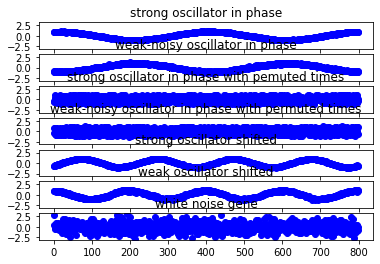

In [59]:
adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix
_, ax = plt.subplots(7, sharex=True, sharey=True)
ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator in phase')
ax[1].plot(np.arange(N), data_df.iloc[NG, :], 'bo'); ax[1].set_title('weak-noisy oscillator in phase')
ax[2].plot(np.arange(N), data_df.iloc[2*NG, :], 'bo'); ax[2].set_title('strong oscillator in phase with pemuted times')
ax[3].plot(np.arange(N), data_df.iloc[3*NG, :], 'bo'); ax[3].set_title('weak-noisy oscillator in phase with permuted times')
ax[4].plot(np.arange(N), data_df.iloc[4*NG, :], 'bo'); ax[4].set_title('strong oscillator shifted')
ax[5].plot(np.arange(N), data_df.iloc[5*NG, :], 'bo'); ax[5].set_title('weak oscillator shifted')
ax[6].plot(np.arange(N), data_df.iloc[6*NG, :], 'bo'); ax[6].set_title('white noise gene')

In [60]:
adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix
n_bootstrap = 100  # number of bootstrap samples
alpha = 0.001  # significance level
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 

adjacency_matrix, qvalues, cost_matrix, psi_ng = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
correct_ratio = get_accuracy(adjacency_matrix, adjacency_matrix_true)
#print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
TPR, FDR, FPR, TP, TN, FP, FN = get_metrics_for_different_qvalue_thresholds2(qvalues, adjacency_matrix_true, np.array([alpha]))
TPR, FDR, _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
#print(f'True positive rate {float(TPR:.2f}, False discovery rate {float(FDR):.2f}')
   

/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 2 secs
get_permuted_cost 7 secs
get_pvalues 0 secs
qvalues pi0=0.781, estimated proportion of null features 


In [61]:
    print(f'Ratio of correctly identified pairs {correct_ratio:.2f}')
    print(f'True positive rate {float(TPR):.2f}, False discovery rate {float(FDR):.2f}')



Ratio of correctly identified pairs 1.00
True positive rate 1.00, False discovery rate 0.03


Text(0.5, 1.0, 'estimated adjacency matrix')

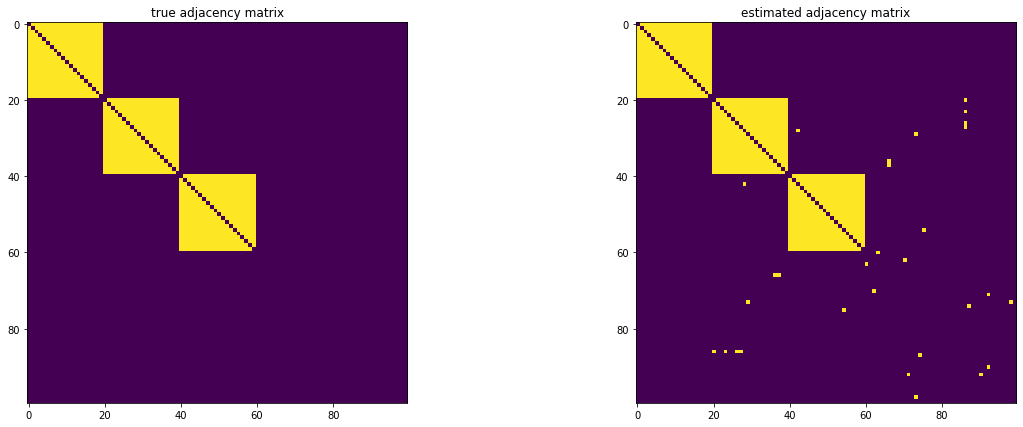

In [62]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

In [64]:
gene_names = data_df.index
edge_network = create_edge_network_representation(adjacency_matrix, 1/cost_matrix, gene_names)
psi_network = create_edge_network_representation(adjacency_matrix, psi_ng, gene_names)

edge_network.to_csv('../Glioblastoma_project/Simulations/3groupsGapCost.csv',index=False)
psi_network.to_csv('../Glioblastoma_project/Simulations/3groupsGapPsi.csv',index=False)
data_df.to_csv('../Glioblastoma_project/Simulations/3groupsGapData.csv')

Sparseness 0.118182
Sparseness 0.118182


In [163]:
psi_ng.shape


(100, 100)

In [167]:
psi_network

,gene1,gene2,weight
0,G1SO0,G1SO1,0.000000
1,G1SO0,G1SO2,0.000000
2,G1SO0,G1SO3,0.000000
3,G1SO0,G1SO4,0.000000
4,G1SO0,G1SO5,0.000000
...,...,...,...
579,R65,R76,1.396263
580,R74,R90,4.886922
581,R80,R89,4.886922
582,R83,R86,4.886922
